In [97]:
from importlib import reload
import qubic.job_manager_jpm as _jm
from matplotlib import pyplot as plt
import chipcalibration.rabi_experiments as _rabi
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as _cfg
import qubic.rpc_client as _rc
import numpy as np

In [98]:
reload(_jm)
reload(_rabi)

<module 'chipcalibration.rabi_experiments' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_experiments.py'>

In [99]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname)

In [100]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner)

# GMM Rabi

In [101]:
register = ['Q1', 'Q2']
target_amplitude = 0.1
pulse_width_interval = np.linspace(0, 10e-9, 10)
pulse_width_interval = pulse_width_interval[1:]

In [102]:
gmm_rabi = _rabi.GMMRabi(register, target_amplitude, pulse_width_interval, 
                       channel_configs=channel_config)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

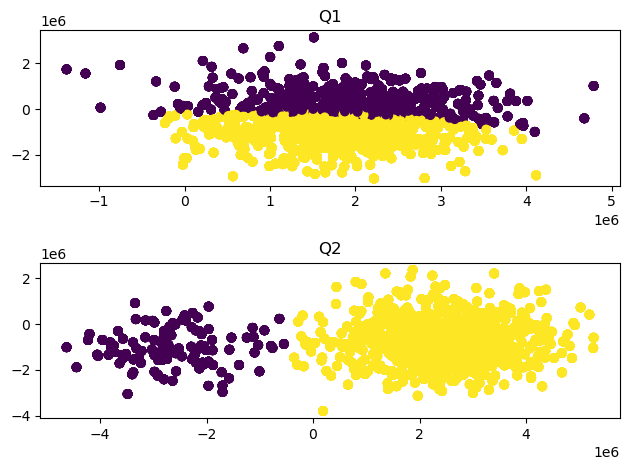

In [103]:
gmm_rabi.run_and_report(jm, 1000, qchip)

In [104]:
data = jm.collect_raw_IQ(gmm_rabi.circuits, 100, qchip)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

In [107]:
np.average(data['4'], axis=1)

array([[1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j],
       [1850122.97-406754.3j]])

In [106]:
gmm_rabi.raw_iq_shots

{'4': array([[[2233502. -766055.j],
         [2324981. -360166.j],
         [3213831. +810778.j],
         ...,
         [1395675.+1145172.j],
         [2197160.-1217996.j],
         [-754033.+1917332.j]],
 
        [[2233502. -766055.j],
         [2324981. -360166.j],
         [3213831. +810778.j],
         ...,
         [1395675.+1145172.j],
         [2197160.-1217996.j],
         [-754033.+1917332.j]],
 
        [[2233502. -766055.j],
         [2324981. -360166.j],
         [3213831. +810778.j],
         ...,
         [1395675.+1145172.j],
         [2197160.-1217996.j],
         [-754033.+1917332.j]],
 
        ...,
 
        [[2233502. -766055.j],
         [2324981. -360166.j],
         [3213831. +810778.j],
         ...,
         [1395675.+1145172.j],
         [2197160.-1217996.j],
         [-754033.+1917332.j]],
 
        [[2233502. -766055.j],
         [2324981. -360166.j],
         [3213831. +810778.j],
         ...,
         [1395675.+1145172.j],
         [2197160.-1217996.j],

In [80]:
gmm_rabi.circuits

[[{'name': 'delay', 't': 0.0004, 'qubit': ['Q1', 'Q2']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   'modi': {(0, 'twidth'): 1.111111111111111e-09},
   (0, 'amp'): 0.1},
  {'name': 'barrier', 'qubit': ['Q1', 'Q2']},
  {'name': 'read', 'qubit': ['Q1']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q1', 'Q2']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   'modi': {(0, 'twidth'): 2.222222222222222e-09},
   (0, 'amp'): 0.1},
  {'name': 'barrier', 'qubit': ['Q1', 'Q2']},
  {'name': 'read', 'qubit': ['Q1']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q1', 'Q2']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   'modi': {(0, 'twidth'): 3.3333333333333334e-09},
   (0, 'amp'): 0.1},
  {'name': 'barrier', 'qubit': ['Q1', 'Q2']},
  {'name': 'read', 'qubit': ['Q1']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q1', 'Q2']},
  {'name': 'rabi',
   'qubit': ['Q1'],
   'modi': {(0, 'twidth'): 4.4444444

In [89]:
sum(gmm_rabi.shots['Q2'][1, :, 0] - gmm_rabi.shots['Q2'][6, :, 0])

0

In [96]:
gmm_rabi.raw_iq_shots['4'][:, 11, 0]

array([1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j,
       1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j,
       1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j,
       1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j,
       1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j,
       1513571.+3125220.j, 1513571.+3125220.j, 1513571.+3125220.j])

In [86]:
gmm_rabi.shots['Q2'].shape

(18, 1000, 1)

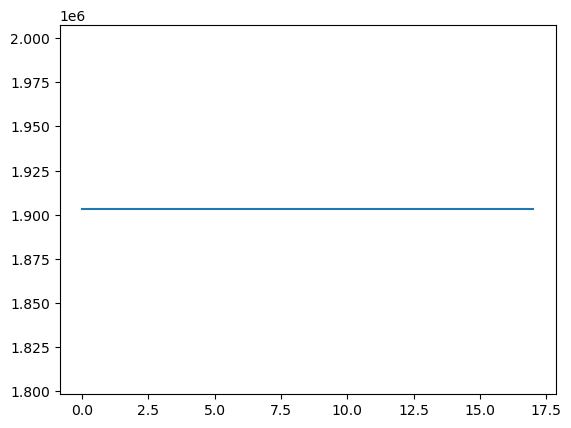

In [88]:
plt.plot(np.average(gmm_rabi.raw_iq_shots['1'].real, axis=1))

In [27]:
gmm_manager = gmm_rabi.gmm_manager

# Time Rabi

I'll target Q2, this time I'll use a jobmanager with a gmm manager 

In [ ]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, gmm_manager)

In [28]:
trabi = _rabi.TimeRabi(['Q2'], ['Q1', 'Q2'], target_amplitude, 
                      pulse_width_interval, gmm_manager)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
hey
> /home/jpmarceaux/chipcalibration/chipcalibration/rabi_expe

KeyError: 'Q1'

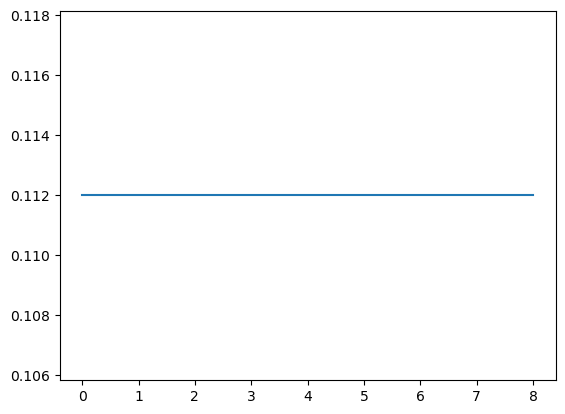

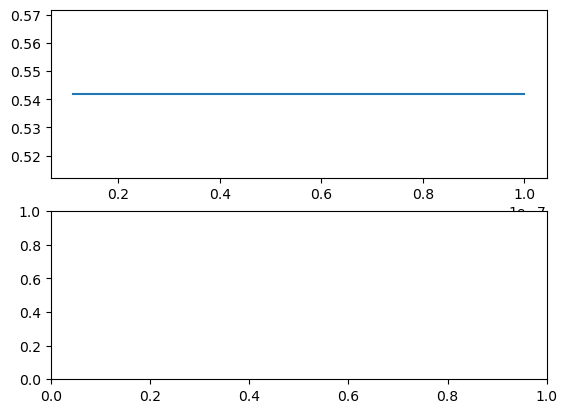

In [203]:
trabi.run_and_report(jm, 1000, qchip)

In [204]:
shots = trabi.shots
avg_response = np.average(shots['Q1'], axis=1)

In [212]:
sum(shots['Q1'][0, :, 0] - shots['Q1'][1, :, 0] )

0

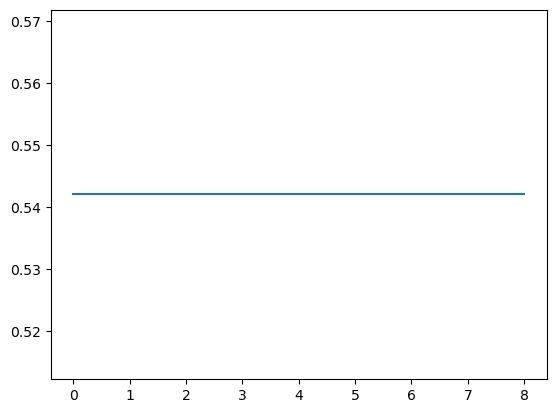

In [205]:
plt.plot(avg_response)

In [169]:
np.fft.rfftfreq(len(average_response), np.diff(self.pulse_widths)[0])[freq_ind_max]

NameError: name 'average_response' is not defined

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
hey
> /home/jpmarceaux/chipcalibration/chipcalibration/rabi_expe

KeyError: 'Q1'

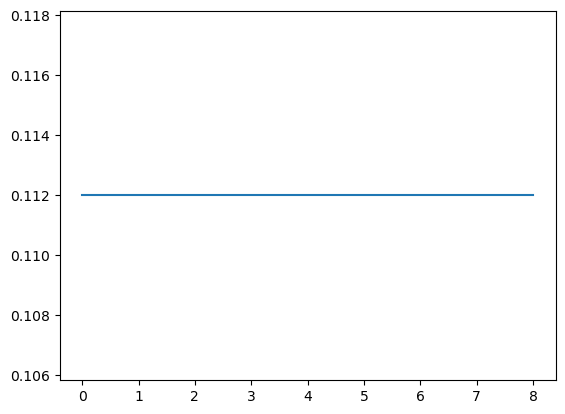

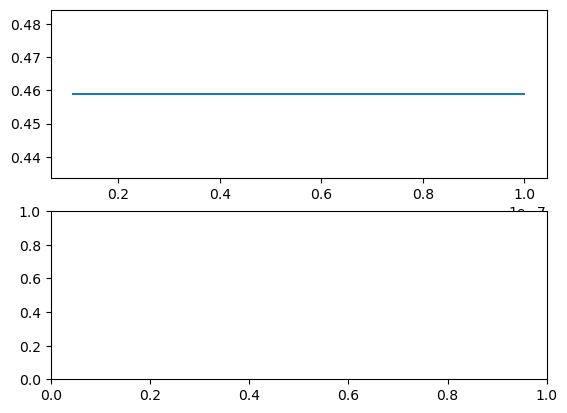

In [197]:
trabi.run_and_report(jm, 1000, qchip)

In [167]:
trabi._fit_data(trabi.shots)

AttributeError: 'TimeRabi' object has no attribute 'shots'

In [199]:
shots = trabi.shots
avg_response = np.average(shots['Q1'], axis=1)

AttributeError: 'TimeRabi' object has no attribute 'shots'

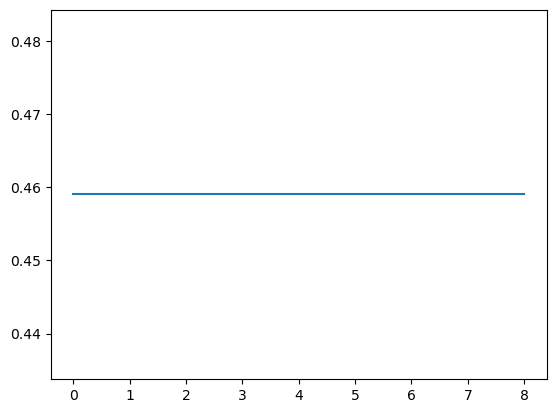

In [200]:
plt.plot(avg_response)

In [176]:
np.fft.rfft(avg_response)

array([[0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j]])

In [176]:
np.fft.rfft(avg_response)

array([[0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j],
       [0.459+0.j]])